In [94]:
import os.path as osp
import pickle
import random

import cv2
import numpy as np
import torch

import lmdb
import os

import numpy as np
from torch.utils.data import Dataset
import torchvision

In [95]:
class BaseDataset(Dataset):
    def __init__(self, data_opt, **kwargs):
        # dict to attr
        for kw, args in data_opt.__dict__.items():
            setattr(self, kw, args)


    def __len__(self):
        pass

    def __getitem__(self, item):
        pass

    def check_info(self, gt_keys, lr_keys):
        if len(gt_keys) != len(lr_keys):
            raise ValueError(
                f'GT & LR contain different numbers of images ({len(gt_keys)}  vs. {len(lr_keys)})')

        for i, (gt_key, lr_key) in enumerate(zip(gt_keys, lr_keys)):
            gt_info = self.parse_lmdb_key(gt_key)
            lr_info = self.parse_lmdb_key(lr_key)

            if gt_info[0] != lr_info[0]:
                raise ValueError(
                    f'video index mismatch ({gt_info[0]} vs. {lr_info[0]} for the {i} key)')

            gt_num, gt_h, gt_w = gt_info[1]
            lr_num, lr_h, lr_w = lr_info[1]
            s = 1
            if (gt_num != lr_num) or (gt_h != lr_h * s) or (gt_w != lr_w * s):
                print(gt_num, lr_num, gt_h, lr_h, gt_w, lr_w)
                raise ValueError(
                    f'video size mismatch ({gt_info[1]} vs. {lr_info[1]} for the {i} key)')

            if gt_info[2] != lr_info[2]:
                raise ValueError(
                    f'frame mismatch ({gt_info[2]} vs. {lr_info[2]} for the {i} key)')

    @staticmethod
    def init_lmdb(seq_dir):
        env = lmdb.open(
            seq_dir, readonly=True, lock=False, readahead=False, meminit=False)
        return env

    @staticmethod
    def parse_lmdb_key(key):
        key_lst = key.split('_')
        idx, size, frm = key_lst[:-2], key_lst[-2], int(key_lst[-1])
        idx = '_'.join(idx)
        size = tuple(map(int, size.split('x')))  # n_frm, h, w
        return idx, size, frm

    @staticmethod
    def read_lmdb_frame(env, key, size):
        with env.begin(write=False) as txn:
            buf = txn.get(key.encode('ascii'))
        frm = np.frombuffer(buf, dtype=np.uint8).reshape(*size)
        return frm

    def crop_sequence(self, **kwargs):
        pass

    @staticmethod
    def augment_sequence(**kwargs):
        pass

In [108]:
class PairedLMDBDataset(BaseDataset):
    """ LMDB dataset for paired data (for BI degradation)
    """

    def __init__(self, data_opt, **kwargs):
        super(PairedLMDBDataset, self).__init__(data_opt, **kwargs)
        
        self.gt_seq_dir = data_opt.gt_seq_dir
        self.lr_seq_dir = data_opt.lr_seq_dir
        self.data_type = data_opt.data_type
        self.scale = data_opt.scale
        self.tempo_extent = data_opt.tempo_extent
        self.moving_first_frame = data_opt.moving_first_frame
        self.moving_factor = data_opt.moving_factor
        self.gt_crop_size = data_opt.gt_crop_size
        self.filter_file = data_opt.filter_file
        
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256, 256))])

        # load meta info
        gt_meta = pickle.load(
            open(osp.join(self.gt_seq_dir, 'meta_info.pkl'), 'rb'))
        lr_meta = pickle.load(
            open(osp.join(self.lr_seq_dir, 'meta_info.pkl'), 'rb'))
        gt_keys = sorted(gt_meta['keys'])
        lr_keys = sorted(lr_meta['keys'])

        self.check_info(gt_keys, lr_keys)
        self.gt_lr_keys = list(zip(gt_keys, lr_keys))

        # use partial videos
        if hasattr(self, 'filter_file') and self.filter_file is not None:
            with open(self.filter_file, 'r') as f:
                sel_seqs = { line.strip() for line in f }
            self.gt_lr_keys = list(filter(
                lambda x: self.parse_lmdb_key(x[0])[0] in sel_seqs, self.gt_lr_keys))

        # register parameters
        self.gt_env = None
        self.lr_env = None

    def __len__(self):
        return len(self.gt_lr_keys)

    def __getitem__(self, item):
        if self.gt_env is None:
            self.gt_env = self.init_lmdb(self.gt_seq_dir)
        if self.lr_env is None:
            self.lr_env = self.init_lmdb(self.lr_seq_dir)

        # parse info
        gt_key, lr_key = self.gt_lr_keys[item]
        idx, (tot_frm, gt_h, gt_w), cur_frm = self.parse_lmdb_key(gt_key)
        _, (_, lr_h, lr_w), _ = self.parse_lmdb_key(lr_key)

        c = 3 if self.data_type.lower() == 'rgb' else 1
        s = self.scale
        assert (gt_h == lr_h * s) and (gt_w == lr_w * s)

        # get frames
        gt_frms, lr_frms = [], []
        if self.moving_first_frame and (random.uniform(0, 1) > self.moving_factor):
            # load the first gt&lr frame
            gt_frm = self.read_lmdb_frame(
                self.gt_env, gt_key, size=(gt_h, gt_w, c))
            gt_frm = gt_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            lr_frm = self.read_lmdb_frame(
                self.lr_env, lr_key, size=(lr_h, lr_w, c))
            lr_frm = lr_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            # generate random moving parameters
            offsets = np.floor(
                np.random.uniform(-1.5, 1.5, size=(self.tempo_extent, 2)))
            offsets = offsets.astype(np.int32)
            pos = np.cumsum(offsets, axis=0)
            min_pos = np.min(pos, axis=0)
            topleft_pos = pos - min_pos
            range_pos = np.max(pos, axis=0) - min_pos
            c_h, c_w = lr_h - range_pos[0], lr_w - range_pos[1]

            # generate frames
            for i in range(self.tempo_extent):
                lr_top, lr_left = topleft_pos[i]
                lr_frms.append(lr_frm[
                    :, lr_top: lr_top + c_h, lr_left: lr_left + c_w].copy())

                gt_top, gt_left = lr_top * s, lr_left * s
                gt_frms.append(gt_frm[
                    :, gt_top: gt_top + c_h * s, gt_left: gt_left + c_w * s].copy())
        else:
            # read frames
            for i in range(cur_frm, cur_frm + self.tempo_extent):
                if i >= tot_frm:
                    # reflect temporal paddding, e.g., (0,1,2) -> (0,1,2,1,0)
                    gt_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, gt_h, gt_w, 2 * tot_frm - i - 2)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, 2 * tot_frm - i - 2)
                else:
                    gt_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, gt_h, gt_w, i)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, i)

                gt_frm = self.read_lmdb_frame(
                    self.gt_env, gt_key, size=(gt_h, gt_w, c))
                gt_frm = gt_frm.transpose(2, 0, 1)  # chw|rgb|uint8
                gt_frms.append(gt_frm)

                lr_frm = self.read_lmdb_frame(
                    self.lr_env, lr_key, size=(lr_h, lr_w, c))
                lr_frm = lr_frm.transpose(2, 0, 1)
                lr_frms.append(lr_frm)

        gt_frms = np.stack(gt_frms)  # tchw|rgb|uint8
        lr_frms = np.stack(lr_frms)

        # crop randomly
        #gt_pats, lr_pats = self.crop_sequence(gt_frms, lr_frms)

        # augment patches
        #gt_pats, lr_pats = self.augment_sequence(gt_pats, lr_pats)

        gt_pats, lr_pats = gt_frms, lr_frms

        # convert to tensor and normalize to range [0, 1]
        gt_tsr = torch.FloatTensor(np.ascontiguousarray(gt_pats)) / 255.0
        lr_tsr = torch.FloatTensor(np.ascontiguousarray(lr_pats)) / 255.0
        
        gt_tsr = self.transform(gt_tsr)
        lr_tsr = self.transform(lr_tsr)

        # tchw|rgb|float32
        return {'gt': gt_tsr, 'lr': lr_tsr}

    def crop_sequence(self, gt_frms, lr_frms):
        gt_csz = self.gt_crop_size
        lr_csz = self.gt_crop_size // self.scale

        lr_h, lr_w = lr_frms.shape[-2:]
        assert (lr_csz <= lr_h) and (lr_csz <= lr_w), \
            'the crop size is larger than the image size'

        # crop lr
        lr_top = random.randint(0, lr_h - lr_csz)
        lr_left = random.randint(0, lr_w - lr_csz)
        lr_pats = lr_frms[
            ..., lr_top: lr_top + lr_csz, lr_left: lr_left + lr_csz]

        # crop gt
        gt_top = lr_top * self.scale
        gt_left = lr_left * self.scale
        gt_pats = gt_frms[
            ..., gt_top: gt_top + gt_csz, gt_left: gt_left + gt_csz]

        return gt_pats, lr_pats

    @staticmethod
    def augment_sequence(gt_pats, lr_pats):
        # flip
        axis = random.randint(1, 3)
        if axis > 1:
            gt_pats = np.flip(gt_pats, axis)
            lr_pats = np.flip(lr_pats, axis)

        # rotate 90 degree
        k = random.randint(0, 3)
        gt_pats = np.rot90(gt_pats, k, (2, 3))
        lr_pats = np.rot90(lr_pats, k, (2, 3))

        return gt_pats, lr_pats
    
    
'''   
class DatasetConfig:
    def __init__(self, 
                 gt_seq_dir,
                 lr_seq_dir,
                 data_type='rgb',
                 scale=2,
                 tempo_extent=5,
                 moving_first_frame=False,
                 moving_factor=0.5,
                 gt_crop_size=256,
                 filter_file=None):

class PairedLMDBDataset(Dataset):
    """ LMDB dataset for paired data (for BI degradation) """

    def __init__(self, data_opt: DatasetConfig):
        self.gt_seq_dir = data_opt.gt_seq_dir
        self.lr_seq_dir = data_opt.lr_seq_dir
        self.data_type = data_opt.data_type
        self.scale = data_opt.scale
        self.tempo_extent = data_opt.tempo_extent
        self.moving_first_frame = data_opt.moving_first_frame
        self.moving_factor = data_opt.moving_factor
        self.gt_crop_size = data_opt.gt_crop_size
        self.filter_file = data_opt.filter_file
        
        # load meta info
        gt_meta = pickle.load(
            open(osp.join(self.gt_seq_dir, 'meta_info.pkl'), 'rb'))
        lr_meta = pickle.load(
            open(osp.join(self.lr_seq_dir, 'meta_info.pkl'), 'rb'))
        gt_keys = sorted(gt_meta['keys'])
        lr_keys = sorted(lr_meta['keys'])

        self.check_info(gt_keys, lr_keys)
        self.gt_lr_keys = list(zip(gt_keys, lr_keys))

        # use partial videos
        if self.filter_file is not None:
            with open(self.filter_file, 'r') as f:
                sel_seqs = {line.strip() for line in f}
            self.gt_lr_keys = list(filter(
                lambda x: self.parse_lmdb_key(x[0])[0] in sel_seqs, self.gt_lr_keys))

        # register parameters
        self.gt_env = None
        self.lr_env = None

    def __len__(self):
        return len(self.gt_lr_keys)

    def __getitem__(self, item):
        if self.gt_env is None:
            self.gt_env = self.init_lmdb(self.gt_seq_dir)
        if self.lr_env is None:
            self.lr_env = self.init_lmdb(self.lr_seq_dir)

        # parse info
        gt_key, lr_key = self.gt_lr_keys[item]
        print(gt_key, lr_key)
        idx, (tot_frm, gt_h, gt_w), cur_frm = self.parse_lmdb_key(gt_key)
        _, (_, lr_h, lr_w), _ = self.parse_lmdb_key(lr_key)

        c = 3 if self.data_type.lower() == 'rgb' else 1
        s = self.scale
        assert (gt_h == lr_h * s) and (gt_w == lr_w * s)

        # get frames
        gt_frms, lr_frms = [], []
        if self.moving_first_frame and (random.uniform(0, 1) > self.moving_factor):
            # load the first gt&lr frame
            gt_frm = self.read_lmdb_frame(
                self.gt_env, gt_key, size=(gt_h, gt_w, c))
            gt_frm = gt_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            lr_frm = self.read_lmdb_frame(
                self.lr_env, lr_key, size=(lr_h, lr_w, c))
            lr_frm = lr_frm.transpose(2, 0, 1)  # chw|rgb|uint8

            # generate random moving parameters
            offsets = np.floor(
                np.random.uniform(-1.5, 1.5, size=(self.tempo_extent, 2)))
            offsets = offsets.astype(np.int32)
            pos = np.cumsum(offsets, axis=0)
            min_pos = np.min(pos, axis=0)
            topleft_pos = pos - min_pos
            range_pos = np.max(pos, axis=0) - min_pos
            c_h, c_w = lr_h - range_pos[0], lr_w - range_pos[1]

            # generate frames
            for i in range(self.tempo_extent):
                lr_top, lr_left = topleft_pos[i]
                lr_frms.append(lr_frm[
                    :, lr_top: lr_top + c_h, lr_left: lr_left + c_w].copy())

                gt_top, gt_left = lr_top * s, lr_left * s
                gt_frms.append(gt_frm[
                    :, gt_top: gt_top + c_h * s, gt_left: gt_left + c_w * s].copy())
        else:
            # read frames
            for i in range(cur_frm, cur_frm + self.tempo_extent):
                if i >= tot_frm:
                    # reflect temporal padding, e.g., (0,1,2) -> (0,1,2,1,0)
                    gt_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, gt_h, gt_w, 2 * tot_frm - i - 2)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, 2 * tot_frm - i - 2)
                else:
                    gt_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, gt_h, gt_w, i)
                    lr_key = '{}_{}x{}x{}_{:04d}'.format(
                        idx, tot_frm, lr_h, lr_w, i)

                gt_frm = self.read_lmdb_frame(
                    self.gt_env, gt_key, size=(gt_h, gt_w, c))
                gt_frm = gt_frm.transpose(2, 0, 1)  # chw|rgb|uint8
                gt_frms.append(gt_frm)

                lr_frm = self.read_lmdb_frame(
                    self.lr_env, lr_key, size=(lr_h, lr_w, c))
                lr_frm = lr_frm.transpose(2, 0, 1)
                lr_frms.append(lr_frm)

        gt_frms = np.stack(gt_frms)  # tchw|rgb|uint8
        lr_frms = np.stack(lr_frms)

        # crop randomly
        gt_pats, lr_pats = self.crop_sequence(gt_frms, lr_frms)

        # augment patches
        gt_pats, lr_pats = self.augment_sequence(gt_pats, lr_pats)

        # convert to tensor and normalize to range [0, 1]
        gt_tsr = torch.FloatTensor(np.ascontiguousarray(gt_pats)) / 255.0
        lr_tsr = torch.FloatTensor(np.ascontiguousarray(lr_pats)) / 255.0

        # tchw|rgb|float32
        return {'gt': gt_tsr, 'lr': lr_tsr}

    def crop_sequence(self, gt_frms, lr_frms):
        gt_csz = self.gt_crop_size
        lr_csz = self.gt_crop_size // self.scale

        lr_h, lr_w = lr_frms.shape[-2:]
        assert (lr_csz <= lr_h) and (lr_csz <= lr_w), \
            'the crop size is larger than the image size'

        # crop lr
        lr_top = random.randint(0, lr_h - lr_csz)
        lr_left = random.randint(0, lr_w - lr_csz)
        lr_pats = lr_frms[
            ..., lr_top: lr_top + lr_csz, lr_left: lr_left + lr_csz]

        # crop gt
        gt_top = lr_top * self.scale
        gt_left = lr_left * self.scale
        gt_pats = gt_frms[
            ..., gt_top: gt_top + gt_csz, gt_left: gt_left + gt_csz]

        return gt_pats, lr_pats

    @staticmethod
    def augment_sequence(gt_pats, lr_pats):
        # flip
        axis = random.randint(1, 3)
        if axis > 1:
            gt_pats = np.flip(gt_pats, axis)
            lr_pats = np.flip(lr_pats, axis)

        # rotate 90 degree
        k = random.randint(0, 3)
        gt_pats = np.rot90(gt_pats, k, (2, 3))
        lr_pats = np.rot90(lr_pats, k, (2, 3))

        return gt_pats, lr_pats

    def init_lmdb(self, lmdb_dir):
        # Your implementation to initialize the LMDB environment
        pass

    def read_lmdb_frame(self, env, key, size):
        # Your implementation to read a frame from LMDB
        pass

    def parse_lmdb_key(self, key):
        # Your implementation to parse LMDB key
        pass

    def check_info(self, gt_keys, lr_keys):
        # Your implementation to check the keys info
        pass
'''

'   \nclass DatasetConfig:\n    def __init__(self, \n                 gt_seq_dir,\n                 lr_seq_dir,\n                 data_type=\'rgb\',\n                 scale=2,\n                 tempo_extent=5,\n                 moving_first_frame=False,\n                 moving_factor=0.5,\n                 gt_crop_size=256,\n                 filter_file=None):\n\nclass PairedLMDBDataset(Dataset):\n    """ LMDB dataset for paired data (for BI degradation) """\n\n    def __init__(self, data_opt: DatasetConfig):\n        self.gt_seq_dir = data_opt.gt_seq_dir\n        self.lr_seq_dir = data_opt.lr_seq_dir\n        self.data_type = data_opt.data_type\n        self.scale = data_opt.scale\n        self.tempo_extent = data_opt.tempo_extent\n        self.moving_first_frame = data_opt.moving_first_frame\n        self.moving_factor = data_opt.moving_factor\n        self.gt_crop_size = data_opt.gt_crop_size\n        self.filter_file = data_opt.filter_file\n        \n        # load meta info\n    

In [109]:
class DatasetConfig:
    def __init__(self, 
                 gt_seq_dir,
                 lr_seq_dir,
                 data_type='rgb',
                 scale=1,
                 tempo_extent=5,
                 moving_first_frame=False,
                 moving_factor=0.5,
                 gt_crop_size=256,
                 filter_file=None):
        self.gt_seq_dir = gt_seq_dir
        self.lr_seq_dir = lr_seq_dir
        self.data_type = data_type
        self.scale = scale
        self.tempo_extent = tempo_extent
        self.moving_first_frame = moving_first_frame
        self.moving_factor = moving_factor
        self.gt_crop_size = gt_crop_size
        self.filter_file = filter_file

data_opt = DatasetConfig(
    gt_seq_dir='/media/moose/Moose/Dataset/AMD/',
    lr_seq_dir='/media/moose/Moose/Dataset/AMD/',
    data_type='rgb',
    scale=1,
    tempo_extent=10,
    moving_first_frame=False,
    moving_factor=0.5,
    gt_crop_size=256,
    filter_file=None
)


In [110]:
ds = PairedLMDBDataset(data_opt)

In [111]:
ds[0]['gt'].shape

torch.Size([10, 3, 256, 256])

In [112]:
ds[0]['lr'].shape

torch.Size([10, 3, 256, 256])

In [113]:
import matplotlib.pyplot as plt

In [115]:
img=ds[40]['gt'][0].permute(1,2,0).numpy()

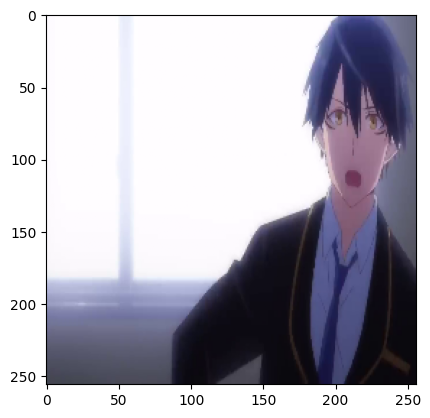

In [116]:
plt.imshow(img)

In [91]:
len(ds)

35760